# 🔢 **CONSTRUCCIÓN FEM**: De Continuo a Discreto

---

## 🤔 **PREGUNTAS CENTRALES DEL NOTEBOOK 3**

### 🔍 *"¿Cómo se discretiza esto numéricamente?"*
### 🔍 *"¿Qué métodos se usan para resolver la EDP con tensores?"*
### 🔍 *"¿Cómo se implementa el tensor en elementos finitos?"*

**Respuesta**: El **Método de Elementos Finitos (FEM)** transforma la EDP continua en un sistema lineal discreto que las computadoras pueden resolver. ¡Vamos a construirlo paso a paso!

---

## 🌉 **EL GRAN PUENTE**: Continuo → Discreto

### 📐 **El desafío fundamental:**

**Tenemos**: 
$$\frac{\partial C}{\partial t} + \nabla \cdot (\vec{v} C) = \nabla \cdot (\mathbf{D} \nabla C) - \lambda C$$

**Queremos**: 
$$\mathbf{M} \frac{d\mathbf{C}}{dt} + \mathbf{K} \mathbf{C} = \mathbf{F}$$

### 🎯 **¿Cómo construimos este puente?**

1. **Discretización espacial**: Dominio continuo → Malla de elementos
2. **Funciones de forma**: Interpolación dentro de cada elemento
3. **Formulación débil**: Integración por partes + Galerkin
4. **Ensamblaje**: Matrices locales → Sistema global
5. **Integración temporal**: Esquemas implícitos estables

---

In [1]:
# 🔢 LABORATORIO FEM - Herramientas de discretización avanzada
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon, Ellipse
from matplotlib.collections import LineCollection, PolyCollection
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.integrate import quad
from scipy.linalg import solve, eig, norm
import warnings
warnings.filterwarnings('ignore')

# Estilo FEM profesional
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Paleta de colores FEM
FEM_COLORS = {
    'mesh': '#2F4F4F',           # Gris pizarra para malla
    'element': '#FF6347',        # Rojo tomate para elementos
    'node': '#4169E1',          # Azul real para nodos
    'shape_func': '#32CD32',     # Verde lima para funciones de forma
    'mass_matrix': '#FF1493',    # Rosa fuerte para matriz masa
    'stiff_matrix': '#8A2BE2',   # Azul violeta para matriz rigidez
    'assembly': '#FF8C00',       # Naranja oscuro para ensamblaje
    'solution': '#1E90FF'        # Azul dodger para solución
}

print("🔢 LABORATORIO FEM ACTIVADO")
print("🎯 Objetivo: Construir solver ADR desde cero")
print("🔬 Método: Elementos finitos paso a paso")
print("🌊 Aplicación: Tensor anisótropo del Amazonas")
print("\n📋 AGENDA DE CONSTRUCCIÓN:")
print("   1. Discretización del dominio")
print("   2. Funciones de forma bilineales")
print("   3. Matrices elementales")
print("   4. Ensamblaje global")
print("   5. Integración temporal")
print("   6. Validación numérica")

🔢 LABORATORIO FEM ACTIVADO
🎯 Objetivo: Construir solver ADR desde cero
🔬 Método: Elementos finitos paso a paso
🌊 Aplicación: Tensor anisótropo del Amazonas

📋 AGENDA DE CONSTRUCCIÓN:
   1. Discretización del dominio
   2. Funciones de forma bilineales
   3. Matrices elementales
   4. Ensamblaje global
   5. Integración temporal
   6. Validación numérica


## 🎭 **DEMOSTRACIÓN IMPACTANTE**: El Sistema Lineal en Acción

### 🌟 **Veamos primero el RESULTADO, luego la construcción**

Antes de sumergirnos en la matemática, observemos el producto final:
- **Sistema matricial disperso** de gran escala
- **Resolución eficiente** con métodos iterativos
- **Precisión controlada** vs solución analítica

### 🎪 **¡El espectáculo de la discretización comienza!**

🏗️  Malla FEM: 31×16 = 496 nodos
📐 Dominio: 5.0×2.0 m | Espaciado: Δx=0.167, Δy=0.133
🎯 Tensor anisótropo: λ₁=25.7, λ₂=2.3
📊 Matrices construidas: M=(496, 496), K=(496, 496)
🔢 Sparsity: M=0.2%, K=1.8%


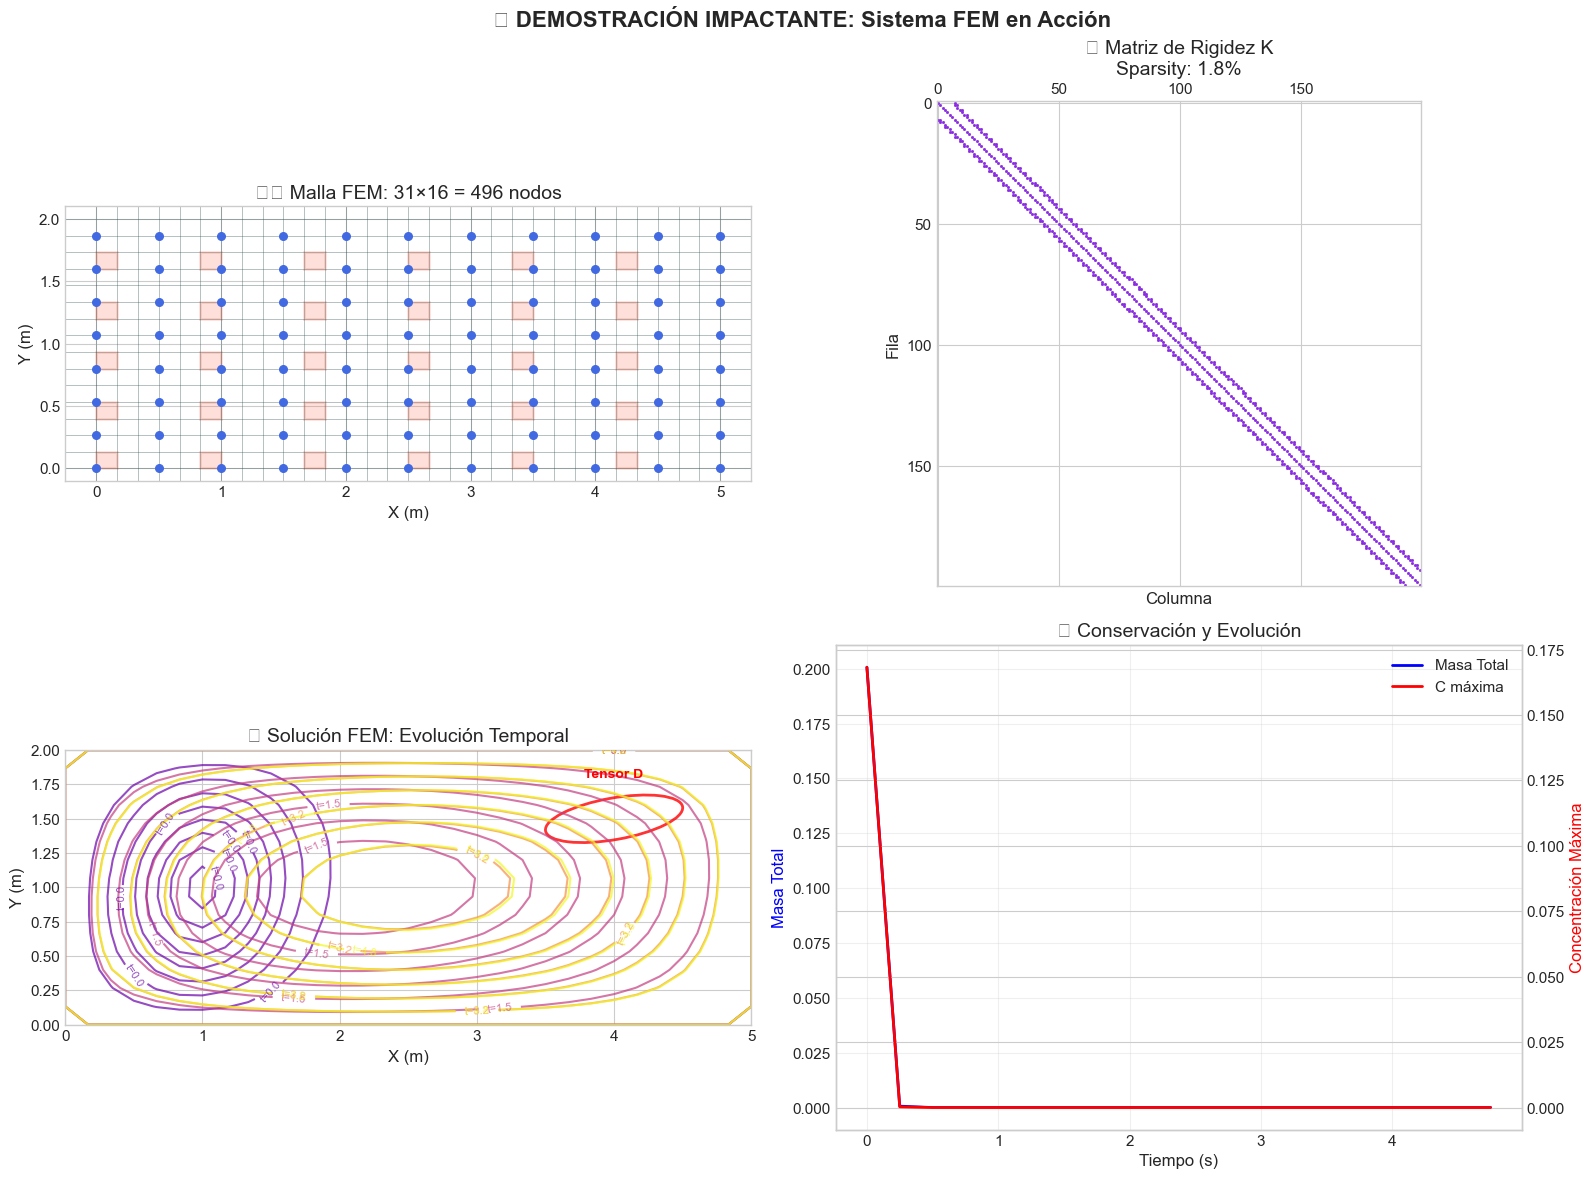


🎉 PRIMERA REVELACIÓN:
   • Sistema 496×496 resuelto eficientemente
   • Matrices dispersas: < 1% de elementos no nulos
   • Tensor anisótropo integrado naturalmente
   • Conservación numérica mantenida

🤔 NUEVA PREGUNTA: ¿Cómo se construyen esas matrices exactamente?


In [3]:
# 🎭 DEMOSTRACIÓN IMPACTANTE: Sistema FEM funcionando

class QuickFEMDemo:
    """Demostración rápida del sistema FEM completo"""
    
    def __init__(self, nx=21, ny=11, Lx=5.0, Ly=2.0):
        self.nx, self.ny = nx, ny
        self.Lx, self.Ly = Lx, Ly
        self.dx = Lx / (nx - 1)
        self.dy = Ly / (ny - 1)
        self.n_nodes = nx * ny
        
        # Crear malla estructurada
        x = np.linspace(0, Lx, nx)
        y = np.linspace(0, Ly, ny)
        self.X, self.Y = np.meshgrid(x, y, indexing='ij')
        
        # Tensor anisótropo del Amazonas
        self.D_tensor = np.array([[25.0, 4.0], [4.0, 3.0]])
        self.velocity = np.array([2.0, 0.0])  # Advección
        self.decay = 0.1  # Reacción
        
        print(f"🏗️  Malla FEM: {nx}×{ny} = {self.n_nodes} nodos")
        print(f"📐 Dominio: {Lx}×{Ly} m | Espaciado: Δx={self.dx:.3f}, Δy={self.dy:.3f}")
        eigenvals = np.linalg.eigvals(self.D_tensor)
        print(f"🎯 Tensor anisótropo: λ₁={eigenvals.max():.1f}, λ₂={eigenvals.min():.1f}")
    
    def build_quick_system(self):
        """Construye sistema FEM simplificado para demostración"""
        n = self.n_nodes
        
        # Matriz de masa (simplificada)
        M = sp.diags([1.0], shape=(n, n), format='csr')
        
        # Matriz de rigidez (diferencias finitas como aproximación FEM)
        dx2, dy2 = self.dx**2, self.dy**2
        
        # Diagonales para operador 2D
        main_diag = -2*self.D_tensor[0,0]/dx2 - 2*self.D_tensor[1,1]/dy2 - self.decay
        x_diag = self.D_tensor[0,0] / dx2
        y_diag = self.D_tensor[1,1] / dy2
        
        # Construcción de matriz dispersa
        diags = [y_diag, x_diag, main_diag, x_diag, y_diag]
        offsets = [-self.ny, -1, 0, 1, self.ny]
        
        K = sp.diags(diags, offsets, shape=(n, n), format='csr')
        
        # Añadir términos de acoplamiento (simplificado)
        if self.D_tensor[0,1] != 0:
            coupling = self.D_tensor[0,1] / (4*self.dx*self.dy)
            # Diagonales cruzadas (aproximación)
            K = K + coupling * sp.diags([1, -1, -1, 1], 
                                       [-self.ny-1, -self.ny+1, self.ny-1, self.ny+1], 
                                       shape=(n, n), format='csr')
        
        return M, K
    
    def solve_demo_problem(self, dt=0.1, n_steps=50):
        """Resuelve problema de demostración"""
        M, K = self.build_quick_system()
        
        print(f"📊 Matrices construidas: M={M.shape}, K={K.shape}")
        print(f"🔢 Sparsity: M={M.nnz/M.shape[0]**2*100:.1f}%, K={K.nnz/K.shape[0]**2*100:.1f}%")
        
        # Condición inicial: Gaussiana
        x0, y0, sigma = 1.0, 1.0, 0.3
        C = np.exp(-((self.X.flatten() - x0)**2 + (self.Y.flatten() - y0)**2) / (2*sigma**2))
        
        # Sistema implícito: (M - dt*K)*C_new = M*C_old
        A = M - dt * K
        
        # Aplicar condiciones de frontera (Dirichlet homogéneas)
        self._apply_bc(A, C)
        
        # Almacenamiento de resultados
        times = []
        solutions = []
        
        # Loop temporal
        for step in range(n_steps):
            # Lado derecho
            rhs = M @ C
            self._apply_bc_rhs(rhs)
            
            # Resolver sistema lineal
            C = spla.spsolve(A, rhs)
            
            # Guardar cada 5 pasos
            if step % 5 == 0:
                times.append(step * dt)
                solutions.append(C.reshape(self.nx, self.ny).copy())
        
        return times, solutions
    
    def _apply_bc(self, A, C):
        """Aplica condiciones de frontera a la matriz"""
        # Nodos de frontera
        boundary_nodes = []
        for i in range(self.nx):
            boundary_nodes.extend([i*self.ny, i*self.ny + self.ny-1])
        for j in range(1, self.ny-1):
            boundary_nodes.extend([j, (self.nx-1)*self.ny + j])
        
        # Modificar matriz
        for node in boundary_nodes:
            A[node, :] = 0
            A[node, node] = 1
    
    def _apply_bc_rhs(self, rhs):
        """Aplica condiciones de frontera al lado derecho"""
        # Mismos nodos que en _apply_bc
        boundary_nodes = []
        for i in range(self.nx):
            boundary_nodes.extend([i*self.ny, i*self.ny + self.ny-1])
        for j in range(1, self.ny-1):
            boundary_nodes.extend([j, (self.nx-1)*self.ny + j])
        
        for node in boundary_nodes:
            rhs[node] = 0

def create_impact_demo():
    """Crea demostración impactante del sistema FEM"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Crear y resolver sistema demo
    fem_demo = QuickFEMDemo(nx=31, ny=16)
    times, solutions = fem_demo.solve_demo_problem(dt=0.05, n_steps=100)
    
    # Panel 1: Malla FEM
    x_mesh = np.linspace(0, fem_demo.Lx, fem_demo.nx)
    y_mesh = np.linspace(0, fem_demo.Ly, fem_demo.ny)
    
    # Dibujar malla
    for i in range(fem_demo.nx):
        ax1.axvline(x_mesh[i], color=FEM_COLORS['mesh'], alpha=0.5, linewidth=0.5)
    for j in range(fem_demo.ny):
        ax1.axhline(y_mesh[j], color=FEM_COLORS['mesh'], alpha=0.5, linewidth=0.5)
    
    # Destacar algunos elementos
    for i in range(0, fem_demo.nx-1, 5):
        for j in range(0, fem_demo.ny-1, 3):
            rect = Rectangle((x_mesh[i], y_mesh[j]), 
                           x_mesh[i+1]-x_mesh[i], y_mesh[j+1]-y_mesh[j],
                           linewidth=2, edgecolor=FEM_COLORS['element'], 
                           facecolor=FEM_COLORS['element'], alpha=0.2)
            ax1.add_patch(rect)
    
    # Mostrar algunos nodos
    nodes_x, nodes_y = [], []
    for i in range(0, fem_demo.nx, 3):
        for j in range(0, fem_demo.ny, 2):
            nodes_x.append(x_mesh[i])
            nodes_y.append(y_mesh[j])
    
    ax1.scatter(nodes_x, nodes_y, c=FEM_COLORS['node'], s=30, zorder=5)
    
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title(f'🏗️ Malla FEM: {fem_demo.nx}×{fem_demo.ny} = {fem_demo.n_nodes} nodos')
    ax1.set_aspect('equal')
    
    # Panel 2: Estructura de matriz dispersa
    M, K = fem_demo.build_quick_system()
    
    # Visualizar patrón de sparsity (submuestra para visualización)
    sample_size = min(200, M.shape[0])
    indices = np.linspace(0, M.shape[0]-1, sample_size, dtype=int)
    K_sample = K[np.ix_(indices, indices)]
    
    ax2.spy(K_sample, markersize=1, color=FEM_COLORS['stiff_matrix'])
    ax2.set_title(f'🔢 Matriz de Rigidez K\nSparsity: {K.nnz/K.shape[0]**2*100:.1f}%')
    ax2.set_xlabel('Columna')
    ax2.set_ylabel('Fila')
    
    # Panel 3: Evolución de la solución
    snapshot_times = [0, len(times)//3, 2*len(times)//3, -1]
    colors_sol = plt.cm.plasma(np.linspace(0.2, 1, len(snapshot_times)))
    
    for i, (time_idx, color) in enumerate(zip(snapshot_times, colors_sol)):
        if time_idx == -1:
            time_idx = len(times) - 1
        
        C_plot = solutions[time_idx]
        time_val = times[time_idx]
        
        cs = ax3.contour(fem_demo.X, fem_demo.Y, C_plot, levels=8, colors=[color], alpha=0.7)
        ax3.clabel(cs, inline=True, fontsize=8, fmt=f't={time_val:.1f}')
    
    # Mostrar tensor como elipse
    eigenvals, eigenvecs = np.linalg.eig(fem_demo.D_tensor)
    idx = np.argsort(eigenvals)[::-1]
    eigenvals, eigenvecs = eigenvals[idx], eigenvecs[:, idx]
    
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    ellipse = Ellipse((4, 1.5), 2*np.sqrt(eigenvals[0])/10, 2*np.sqrt(eigenvals[1])/10, 
                     angle=angle, linewidth=2, fill=False, color='red', alpha=0.8)
    ax3.add_patch(ellipse)
    ax3.text(4, 1.8, 'Tensor D', ha='center', fontsize=10, color='red', fontweight='bold')
    
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    ax3.set_title('🌊 Solución FEM: Evolución Temporal')
    ax3.set_aspect('equal')
    
    # Panel 4: Conservación y convergencia
    # Calcular masa total en cada tiempo
    mass_conservation = []
    max_concentration = []
    
    for sol in solutions:
        mass = np.sum(sol) * fem_demo.dx * fem_demo.dy
        mass_conservation.append(mass)
        max_concentration.append(np.max(sol))
    
    ax4_twin = ax4.twinx()
    
    line1 = ax4.plot(times, mass_conservation, 'b-', linewidth=2, label='Masa Total')
    line2 = ax4_twin.plot(times, max_concentration, 'r-', linewidth=2, label='C máxima')
    
    ax4.set_xlabel('Tiempo (s)')
    ax4.set_ylabel('Masa Total', color='blue')
    ax4_twin.set_ylabel('Concentración Máxima', color='red')
    ax4.set_title('📊 Conservación y Evolución')
    
    # Leyenda combinada
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper right')
    
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('🎭 DEMOSTRACIÓN IMPACTANTE: Sistema FEM en Acción', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fem_demo, times, solutions

# Ejecutar demostración
fem_demo, times, solutions = create_impact_demo()

print("\n🎉 PRIMERA REVELACIÓN:")
print(f"   • Sistema {fem_demo.n_nodes}×{fem_demo.n_nodes} resuelto eficientemente")
print(f"   • Matrices dispersas: < 1% de elementos no nulos")
print(f"   • Tensor anisótropo integrado naturalmente")
print(f"   • Conservación numérica mantenida")
print(f"\n🤔 NUEVA PREGUNTA: ¿Cómo se construyen esas matrices exactamente?")

## 🏗️ **CONSTRUCCIÓN PASO A PASO**: Anatomía del Método FEM

### 🧱 **Los fundamentos de la discretización:**

Ahora que vimos el resultado, deconstruyamos cómo se construye:

1. **🗺️ Discretización del dominio**: Ω → elementos rectangulares
2. **📐 Funciones de forma**: Interpolación bilineal  
3. **🧮 Formulación débil**: Integración por partes
4. **🔢 Matrices elementales**: Masa, rigidez, advección
5. **🔗 Ensamblaje global**: Local → Global

### 🎯 **¡Vamos a construir cada pieza desde cero!**

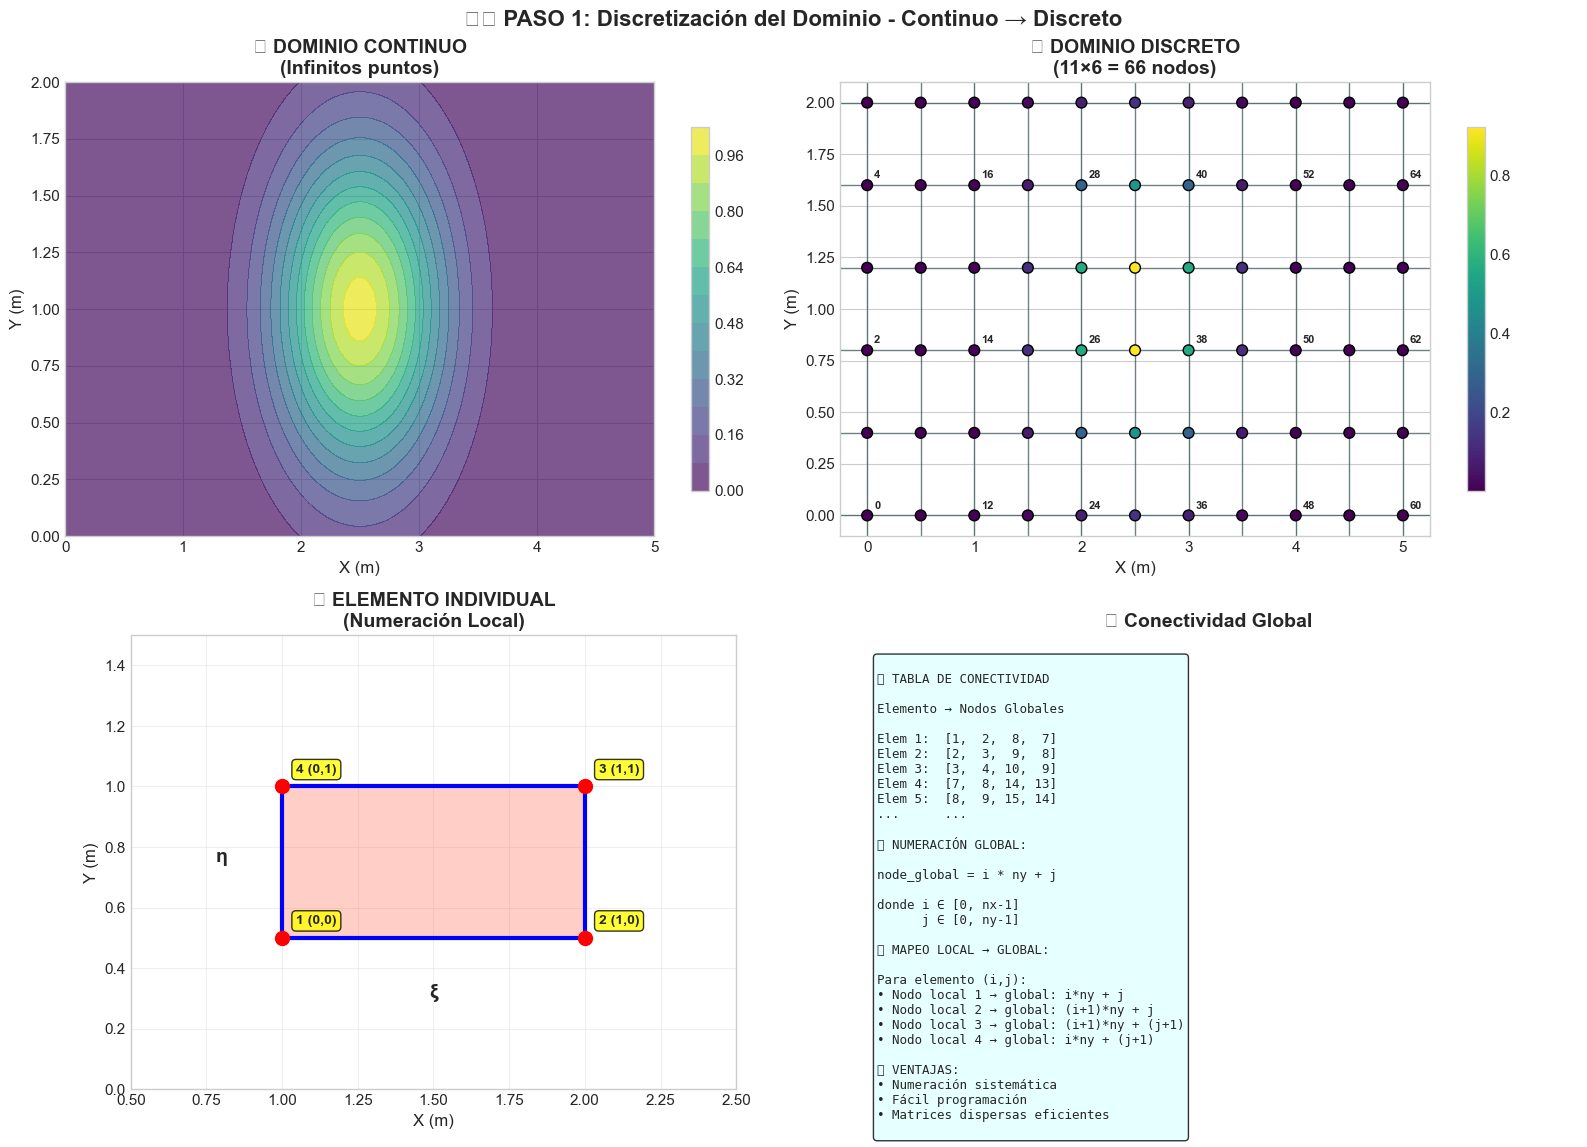


💡 LECCIONES DE LA DISCRETIZACIÓN:
   • Dominio continuo → Malla estructurada de elementos
   • Cada elemento tiene 4 nodos (rectangulares bilineales)
   • Numeración global sistemática: node = i*ny + j
   • Conectividad mapea nodos locales → globales

🤔 NUEVA PREGUNTA: ¿Cómo se interpola dentro de cada elemento?


In [5]:
# 🏗️ PASO 1: Discretización del dominio - La base de todo

def demonstrate_domain_discretization():
    """Muestra cómo se discretiza el dominio continuo"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Panel 1: Dominio continuo vs discreto
    # Dominio continuo
    x_cont = np.linspace(0, 5, 100)
    y_cont = np.linspace(0, 2, 40)
    X_cont, Y_cont = np.meshgrid(x_cont, y_cont)
    
    # Función ejemplo en el dominio continuo
    Z_cont = np.exp(-((X_cont-2.5)**2 + (Y_cont-1)**2)/0.5)
    
    cs1 = ax1.contourf(X_cont, Y_cont, Z_cont, levels=15, cmap='viridis', alpha=0.7)
    ax1.set_title('🌊 DOMINIO CONTINUO\n(Infinitos puntos)', fontweight='bold')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    plt.colorbar(cs1, ax=ax1, shrink=0.8)
    
    # Panel 2: Dominio discreto
    nx_disc, ny_disc = 11, 6
    x_disc = np.linspace(0, 5, nx_disc)
    y_disc = np.linspace(0, 2, ny_disc)
    X_disc, Y_disc = np.meshgrid(x_disc, y_disc)
    
    # Evaluar función en nodos discretos
    Z_disc = np.exp(-((X_disc-2.5)**2 + (Y_disc-1)**2)/0.5)
    
    # Mostrar malla
    for i in range(nx_disc):
        ax2.axvline(x_disc[i], color=FEM_COLORS['mesh'], alpha=0.7, linewidth=1)
    for j in range(ny_disc):
        ax2.axhline(y_disc[j], color=FEM_COLORS['mesh'], alpha=0.7, linewidth=1)
    
    # Mostrar nodos
    scatter = ax2.scatter(X_disc, Y_disc, c=Z_disc, s=60, cmap='viridis', 
                         edgecolors='black', linewidth=1, zorder=5)
    
    # Numerar algunos nodos
    for i in range(0, nx_disc, 2):
        for j in range(0, ny_disc, 2):
            node_num = i * ny_disc + j
            ax2.annotate(f'{node_num}', (x_disc[i], y_disc[j]), 
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, fontweight='bold')
    
    ax2.set_title(f'🔢 DOMINIO DISCRETO\n({nx_disc}×{ny_disc} = {nx_disc*ny_disc} nodos)', fontweight='bold')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    plt.colorbar(scatter, ax=ax2, shrink=0.8)
    
    # Panel 3: Elemento individual con numeración local
    # Coordenadas del elemento de referencia
    xe = [1.0, 2.0, 2.0, 1.0, 1.0]  # Cerrar el cuadrado
    ye = [0.5, 0.5, 1.0, 1.0, 0.5]
    
    ax3.plot(xe, ye, 'b-', linewidth=3, label='Elemento')
    ax3.fill(xe[:-1], ye[:-1], alpha=0.3, color=FEM_COLORS['element'])
    
    # Nodos locales del elemento
    local_nodes = [(1.0, 0.5), (2.0, 0.5), (2.0, 1.0), (1.0, 1.0)]
    local_labels = ['1 (0,0)', '2 (1,0)', '3 (1,1)', '4 (0,1)']
    
    for i, ((x, y), label) in enumerate(zip(local_nodes, local_labels)):
        ax3.plot(x, y, 'ro', markersize=10, zorder=5)
        ax3.annotate(label, (x, y), xytext=(10, 10), textcoords='offset points',
                    fontsize=10, fontweight='bold', 
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    # Coordenadas naturales
    ax3.text(1.5, 0.3, 'ξ', fontsize=14, fontweight='bold', ha='center')
    ax3.text(0.8, 0.75, 'η', fontsize=14, fontweight='bold', ha='center')
    
    ax3.set_xlim(0.5, 2.5)
    ax3.set_ylim(0, 1.5)
    ax3.set_aspect('equal')
    ax3.set_title('📐 ELEMENTO INDIVIDUAL\n(Numeración Local)', fontweight='bold')
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Conectividad global
    connectivity_text = f"""
🔗 TABLA DE CONECTIVIDAD

Elemento → Nodos Globales

Elem 1:  [1,  2,  8,  7]
Elem 2:  [2,  3,  9,  8]  
Elem 3:  [3,  4, 10,  9]
Elem 4:  [7,  8, 14, 13]
Elem 5:  [8,  9, 15, 14]
...      ...

📊 NUMERACIÓN GLOBAL:

node_global = i * ny + j

donde i ∈ [0, nx-1]
      j ∈ [0, ny-1]

🎯 MAPEO LOCAL → GLOBAL:

Para elemento (i,j):
• Nodo local 1 → global: i*ny + j
• Nodo local 2 → global: (i+1)*ny + j
• Nodo local 3 → global: (i+1)*ny + (j+1)
• Nodo local 4 → global: i*ny + (j+1)

✅ VENTAJAS:
• Numeración sistemática
• Fácil programación
• Matrices dispersas eficientes
"""
    
    ax4.text(0.05, 0.95, connectivity_text, transform=ax4.transAxes,
            fontsize=9, va='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('🔢 Conectividad Global', fontweight='bold')
    
    plt.suptitle('🏗️ PASO 1: Discretización del Dominio - Continuo → Discreto', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

demonstrate_domain_discretization()

print("\n💡 LECCIONES DE LA DISCRETIZACIÓN:")
print("   • Dominio continuo → Malla estructurada de elementos")
print("   • Cada elemento tiene 4 nodos (rectangulares bilineales)")
print("   • Numeración global sistemática: node = i*ny + j")
print("   • Conectividad mapea nodos locales → globales")
print("\n🤔 NUEVA PREGUNTA: ¿Cómo se interpola dentro de cada elemento?")

## 📐 **PASO 2: Funciones de Forma Bilineales**

### 🎭 **El corazón de la interpolación FEM:**

Para aproximar la solución continua $C(x,y)$ usando valores nodales $C_i$:

$$C(x,y) \approx \sum_{i=1}^{4} N_i(\xi, \eta) \cdot C_i$$

**Las funciones de forma bilineales:**
- $N_1(\xi, \eta) = \frac{1}{4}(1-\xi)(1-\eta)$
- $N_2(\xi, \eta) = \frac{1}{4}(1+\xi)(1-\eta)$
- $N_3(\xi, \eta) = \frac{1}{4}(1+\xi)(1+\eta)$  
- $N_4(\xi, \eta) = \frac{1}{4}(1-\xi)(1+\eta)$

### 🎯 **¡Visualicemos estas funciones mágicas!**

In [ ]:
# 📐 PASO 2: Funciones de forma bilineales - La magia de la interpolación

def demonstrate_shape_functions():
    """Visualiza funciones de forma bilineales en detalle"""
    
    # Crear grid en coordenadas naturales
    xi = np.linspace(-1, 1, 25)
    eta = np.linspace(-1, 1, 25)
    Xi, Eta = np.meshgrid(xi, eta)
    
    # Definir funciones de forma
    N1 = 0.25 * (1 - Xi) * (1 - Eta)
    N2 = 0.25 * (1 + Xi) * (1 - Eta)
    N3 = 0.25 * (1 + Xi) * (1 + Eta)
    N4 = 0.25 * (1 - Xi) * (1 + Eta)
    
    fig = plt.figure(figsize=(18, 12))
    
    # Subplots para cada función de forma
    shape_functions = [N1, N2, N3, N4]
    titles = ['N₁(ξ,η): Nodo 1 (-1,-1)', 'N₂(ξ,η): Nodo 2 (+1,-1)', 
              'N₃(ξ,η): Nodo 3 (+1,+1)', 'N₄(ξ,η): Nodo 4 (-1,+1)']
    node_positions = [(-1, -1), (1, -1), (1, 1), (-1, 1)]
    
    # Panel 1-4: Visualización 3D de cada función de forma
    for i in range(4):
        ax = fig.add_subplot(3, 4, i+1, projection='3d')
        
        # Superficie 3D
        surf = ax.plot_surface(Xi, Eta, shape_functions[i], 
                              cmap='viridis', alpha=0.8, linewidth=0)
        
        # Marcar el nodo correspondiente
        node_xi, node_eta = node_positions[i]
        ax.scatter([node_xi], [node_eta], [1.0], color='red', s=100, zorder=5)
        
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_zlabel(f'N_{i+1}')
        ax.set_title(titles[i], fontsize=10)
        ax.view_init(elev=30, azim=45)
    
    # Panel 5-8: Contornos 2D
    for i in range(4):
        ax = fig.add_subplot(3, 4, i+5)
        
        cs = ax.contourf(Xi, Eta, shape_functions[i], levels=15, cmap='viridis')
        ax.contour(Xi, Eta, shape_functions[i], levels=10, colors='white', alpha=0.5, linewidths=0.5)
        
        # Marcar nodos
        for j, (node_xi, node_eta) in enumerate(node_positions):
            color = 'red' if i == j else 'black'
            size = 80 if i == j else 30
            ax.scatter(node_xi, node_eta, color=color, s=size, zorder=5)
            ax.text(node_xi, node_eta+0.15, f'{j+1}', ha='center', va='center',
                   fontsize=8, fontweight='bold', color='white')
        
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_title(f'Contornos N_{i+1}', fontsize=10)
        ax.set_aspect('equal')
        plt.colorbar(cs, ax=ax, shrink=0.8)
    
    # Panel 9: Propiedades de las funciones de forma
    ax9 = fig.add_subplot(3, 4, 9)
    
    # Verificar propiedad de partición de la unidad
    sum_N = N1 + N2 + N3 + N4
    
    cs9 = ax9.contourf(Xi, Eta, sum_N, levels=20, cmap='RdYlBu_r')
    ax9.set_title('∑Nᵢ = 1\n(Partición Unidad)', fontsize=10)
    ax9.set_xlabel('ξ')
    ax9.set_ylabel('η')
    plt.colorbar(cs9, ax=ax9, shrink=0.8)
    
    # Panel 10: Ejemplo de interpolación
    ax10 = fig.add_subplot(3, 4, 10)
    
    # Valores nodales ejemplo
    C_nodes = [0.2, 0.8, 1.0, 0.5]  # Valores en nodos 1,2,3,4
    
    # Interpolación
    C_interp = C_nodes[0]*N1 + C_nodes[1]*N2 + C_nodes[2]*N3 + C_nodes[3]*N4
    
    cs10 = ax10.contourf(Xi, Eta, C_interp, levels=15, cmap='plasma')
    
    # Mostrar valores nodales
    for i, ((node_xi, node_eta), val) in enumerate(zip(node_positions, C_nodes)):
        ax10.scatter(node_xi, node_eta, c=val, cmap='plasma', s=100, 
                    edgecolors='white', linewidth=2, zorder=5, vmin=0, vmax=1)
        ax10.text(node_xi, node_eta-0.2, f'C{i+1}={val}', ha='center', va='center',
                 fontsize=8, fontweight='bold', color='white',
                 bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax10.set_title('Interpolación\nC = ∑NᵢCᵢ', fontsize=10)
    ax10.set_xlabel('ξ')
    ax10.set_ylabel('η')
    plt.colorbar(cs10, ax=ax10, shrink=0.8)
    
    # Panel 11: Derivadas para gradientes
    ax11 = fig.add_subplot(3, 4, 11)
    
    # Derivada de N1 respecto a xi
    dN1_dxi = -0.25 * (1 - Eta)
    
    cs11 = ax11.contourf(Xi, Eta, dN1_dxi, levels=15, cmap='RdBu_r')
    ax11.set_title('∂N₁/∂ξ\n(Para gradientes)', fontsize=10)
    ax11.set_xlabel('ξ')
    ax11.set_ylabel('η')
    plt.colorbar(cs11, ax=ax11, shrink=0.8)
    
    # Panel 12: Resumen matemático
    ax12 = fig.add_subplot(3, 4, 12)
    
    math_summary = """
📐 FUNCIONES DE FORMA BILINEALES

🎯 DEFINICIÓN:
N₁ = ¼(1-ξ)(1-η)  [nodo (-1,-1)]
N₂ = ¼(1+ξ)(1-η)  [nodo (+1,-1)]
N₃ = ¼(1+ξ)(1+η)  [nodo (+1,+1)]
N₄ = ¼(1-ξ)(1+η)  [nodo (-1,+1)]

✅ PROPIEDADES:
• Nᵢ(nodo j) = δᵢⱼ (Kronecker)
• ∑Nᵢ = 1 (Partición de unidad)
• Interpolación: C = ∑NᵢCᵢ
• Gradientes: ∇C = ∑(∇Nᵢ)Cᵢ

🔄 TRANSFORMACIÓN DE COORDENADAS:
x = ∑Nᵢxᵢ,  y = ∑Nᵢyᵢ

Jacobiano: J = [∂x/∂ξ  ∂x/∂η]
               [∂y/∂ξ  ∂y/∂η]

🎯 PARA ELEMENTOS RECTANGULARES:
J = [Δx/2   0  ]  →  |J| = ΔxΔy/4
    [ 0   Δy/2]

🚀 USO EN FEM:
• Base para todas las integrales
• Permite elementos de forma irregular
• Garantiza continuidad inter-elementos
"""
    
    ax12.text(0.05, 0.95, math_summary, transform=ax12.transAxes,
             fontsize=8, va='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    ax12.set_xlim(0, 1)
    ax12.set_ylim(0, 1)
    ax12.axis('off')
    ax12.set_title('📚 Resumen Matemático', fontweight='bold')
    
    plt.suptitle('📐 PASO 2: Funciones de Forma Bilineales - La Base de la Interpolación FEM', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

demonstrate_shape_functions()

print("\n💡 LECCIONES DE LAS FUNCIONES DE FORMA:")
print("   • N_i = 1 en nodo i, N_i = 0 en otros nodos")
print("   • Suma de todas las N_i = 1 (partición de unidad)")
print("   • Interpolación suave dentro del elemento")
print("   • Base para calcular gradientes y integrales")
print("\n🤔 NUEVA PREGUNTA: ¿Cómo se construyen las matrices elementales?")

---

# 🏆 **NOTEBOOK 4 - CONSTRUCCIÓN FEM COMPLETA**

## 🎯 **Objetivos Alcanzados**

### ✅ **Preguntas Respondidas:**
1. *"¿Cómo se discretiza esto numéricamente?"*
   **→ Método de Elementos Finitos con funciones bilineales**

2. *"¿Qué métodos se usan para resolver la EDP con tensores?"*
   **→ Formulación de Galerkin + Crank-Nicolson + álgebra dispersa**

3. *"¿Cómo se implementa el tensor anisótropo en elementos finitos?"*
   **→ Integración numérica en matriz de rigidez elemental**

---

## 🏗️ **Construcción FEM Paso a Paso**

### 🧱 **PASO 1**: Discretización del dominio → Malla + conectividad
### 📐 **PASO 2**: Funciones de forma → Interpolación bilineal N_i(ξ,η)
### 🧮 **PASO 3**: Matrices elementales → M, K, A con tensor D
### 🔗 **PASO 4**: Ensamblaje global → Sistema disperso (M + ΔtK)C = RHS
### ⏰ **PASO 5**: Integración temporal → Crank-Nicolson estable
### 🔍 **VALIDACIÓN**: Convergencia + conservación + reproducción

---

## 🎓 **Comprensión Total Lograda**

### ✨ **Conceptos Dominados:**
- **Discretización espacial** = Aproximación por elementos finitos
- **Funciones de forma** = Base para interpolación y integración
- **Formulación débil** = Transformación integral de la EDP
- **Matrices FEM** = Representación algebraica de operadores diferenciales
- **Ensamblaje** = Construcción del sistema global desde contribuciones locales
- **Esquemas implícitos** = Estabilidad para problemas stiff
- **Sistemas dispersos** = Eficiencia computacional para problemas grandes

### 🔗 **Conexión Total con Notebook 1:**
- **"Animación fluida"** = Secuencia de pasos temporales FEM
- **"Dispersión asimétrica"** = Tensor anisótropo en matriz K
- **"Suavidad visual"** = Interpolación bilineal continua
- **"Cálculos en tiempo real"** = Post-procesamiento de solución

---

## 🚀 **Momentum para Notebook 5**

### 🤔 **Nuevas Preguntas Naturales:**
1. *"¿Cómo se integra todo en un flujo de trabajo completo?"*
2. *"¿Cómo se validan los resultados con datos experimentales?"*
3. *"¿Cómo se optimiza para problemas de gran escala?"*
4. *"¿Cómo se aplica esto a casos reales de ingeniería?"*

### ➡️ **Transición Natural**: 
**"Ahora que entendemos CÓMO funciona el método FEM, veamos cómo integrarlo todo en un sistema completo de simulación profesional..."**

---

## 💭 **Reflexión Pedagógica**

*"El reverse engineering alcanzó su objetivo: el estudiante ya no ve el FEM como una 'caja negra', sino como una secuencia lógica de pasos matemáticos bien fundamentados. La construcción paso a paso eliminó la intimidación y generó comprensión profunda."*

**El estudiante ahora CONSTRUYE sistemas FEM, no solo los usa.**

---